## Projection of Raw Data on Spherical Surface

In [1]:
import os, csv, pickle, gzip, torch
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z
def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output



spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

# ver2 file makes vector feature velocity to hold a and b instead of simple subtraction that is useless
file_name = "0919-f18r16ver2"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])


#=========== group ==================
#depth = (0.9, 1.7, 2.5, 3.3)
#angles = (+-30 azimuth, +-20 elevation)

# 2 5 8
# 1 4 7
# 0 3 6

#cross: 1,3,5,7
#center: 4
#oblique: 0,2,6,8

open gzip


In [2]:
#========= proj functions =========================================================================

%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

def draw_features_by_file(file_name, save_name, ffile, sfile, PARAMS):
    """
    ffile = feature file for subject
    sfile = pointer idx file
    PARAMS = parameter file for all sub sessions
    """
    # GT position is not showing the pattern
    fig, (ax) = plt.subplots(1,1)
    fig.set_size_inches(8,8)
    plt.title("All")
    for fIdx in tqdm(range(144)):        
        colors = cm.rainbow(np.linspace(0, 1, 24))
        # fig, (ax) = plt.subplots(1,1)
        # fig.set_size_inches(8,8)
        # plt.title('file_num: '+str(fIdx+1)+ "/144")

        for sIdx in range(16):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            param = PARAMS[sIdx][pIdx]
            trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
            # print("trimEye, trimEye1", trimHmd[0].shape, trimEye[0].shape, trimEye1[0].shape)
            # print("trimHmd, trimEye, trimEye1", len(trimHmd), len(trimEye), len(trimEye1))
            # print(str(sIdx), " and file distance: ", param[2])

            # ----trim to end Idx------------            
            end_idx = len(trimX[pIdx])-1
            trimHmd = trimHmd[pIdx][:end_idx+1]     #ts
            trimHmd1 = trimHmd1[pIdx][:end_idx+1]     #ts
            trimEye = trimEye[pIdx][:end_idx+1, 0]  #comb eye
            trimEye1 = trimEye1[pIdx][:end_idx+1, 0] #comb eye
            trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
            trimY = trimY[pIdx][:end_idx+1]         #rel_params

            # ----downsample OR use only last frame------------     
#             trimHmd = trimHmd[::40]  
#             trimHmd1 = trimHmd1[::40]
#             trimEye = trimEye[::40]
#             trimEye1 = trimEye1[::40]   
#             trimGTPos =trimGTPos[::40]  
#             trimY = trimY[::40]          
            
            trimHmd = trimHmd[[-1]] #use double bracket to retain dimension in 1-element slicing
            trimHmd1 = trimHmd1[[-1]]
            trimEye = trimEye[[-1]]
            trimEye1 = trimEye1[[-1]]  
            trimGTPos =trimGTPos[[-1]]
            trimY = trimY[[-1]] 

            #----------plot--------------------------------------
            if len(trimX[pIdx]) == 0: # if we are accessing file with 0 length, fill dummy values
                pos0 = torch.full((20, 3), -1)
                pos1 = torch.full((20, 3), -1)
                pos_eye_c = torch.full((20, 3), -1)
                pos_eye_left = torch.full((20, 3), -1)
                pos_eye_right = torch.full((20, 3), -1)
            else:
                pos0 = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1) #GT            
                pos1 = calc_hrc(trimHmd, trimHmd1, param) # 
                pos_eye_c = calc_erc(trimHmd, trimHmd1, trimEye, trimEye1, param)


            # pos0 = pos_to_param(pos0)
            # pos1 = pos_to_param(pos1)
            # pos_eye_c = pos_to_param(pos_eye_c)

            x0, y0 = pos0[:,0], pos0[:,1]
            x1, y1 = pos1[:,0], pos1[:,1]
            x_c, y_c = pos_eye_c[:,0], pos_eye_c[:,1]

            color = np.array([colors[sIdx]])
            ax.scatter(x0, y0, c='r', marker='d', label='gts', alpha=0.2)
            ax.scatter(x1, y1, c='g', marker='+', label='HRC', alpha=0.2)            
            ax.scatter(x_c, y_c, c='b', marker='.', label='ERC_comb', alpha=0.2)
            # ax.scatter(x1[-1], y1[-1], c='r', marker='s', alpha=1)

            pos1_text = 's' + str(sIdx+1) 
            # ax.text(x1[-1], y1[-1], pos1_text)
            ax.set_xlabel('X (meter)')
            ax.set_ylabel('Y (meter)')            
            # ax.set_xlabel('H (degree)')
            # ax.set_ylabel('V (degree)')
            
            if sIdx == 0 and fIdx==0:
                plt.legend()
        plt.xlim([-45,45])
        plt.ylim([-45,45])
        plt.xlim([-2,2])
        plt.ylim([-2,2])

        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)        

        # savename = "f" + str(fIdx+1)
        # fig.savefig(savename)
        #plt.show()        # plt.legend()
    savename = "all 144 files for 16 subjects"
    fig.savefig(savename)



#============================================================
def hmd_pos_to_hmd1_pos(GTPos, hmd_1st_tensor): # GT POS
    '''
    >TRUE SPHERICAL Y SETUP, UNITY -X SETUP
    TENSOR LIST FOR SINGLE FRAME SEQ
    input: e.g.[2200, 3], [2200, 4, 4]
    return: e.g. [2200, 3]
    '''
    l_output= []
    for frame, (gt_pos, hmd_1st) in enumerate(zip(GTPos, hmd_1st_tensor)):
        t_op = torch.eye(4)
        x,y,z = gt_pos[0], gt_pos[1], gt_pos[2]
        t_op[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)
        t_oh = hmd_1st 
        # t_hp = t_ho * t_op = inv(t_oh) * t_op
        t = torch.matmul(torch.linalg.inv(t_oh), t_op)
        l_output.append(t[:3, 3])
    l_output = torch.stack(l_output)

    return l_output

def calc_hrc(hmd, hmd1, param):
    hrc_proj_pos_tensors = []
    azimuth, elevation, distance = param    
    for f, (t_h, t_h1) in enumerate(zip(hmd, hmd1)):    
        t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
        d1 = torch.norm(t_h1h[:3,3])
        d2 = torch.sqrt(distance*distance - d1*d1)
        t_hd2 = torch.eye(4,4)
        t_hd2[2,3] = d2
        t_h1d2 = torch.matmul(t_h1h, t_hd2)
        hrc_proj_pos_tensors.append(t_h1d2[:3,3])
    hrc_proj_pos_tensors = torch.stack(hrc_proj_pos_tensors)
    return hrc_proj_pos_tensors


def calc_erc(hmd, hmd1, eye, eye1, param):
    erc_proj_pos_tensors = []
    azimuth, elevation, distance = param    
    for f, (t_h, t_h1, t_he, t_he1) in enumerate(zip(hmd, hmd1, eye, eye1)):    
        t_h1h = torch.matmul(torch.linalg.inv(t_h1), t_h)
        t_h1e = torch.matmul(t_h1h, t_he)

        d1 = torch.norm(t_h1h[:3,3])
        d2 = torch.sqrt(distance*distance - d1*d1)
        d3 = torch.norm(t_he[:3,3])
        d4 = torch.sqrt(d2*d2 - d3*d3)

        t_ed4 = torch.eye(4,4)
        t_ed4[2,3] = d4
        t_h1d4 = torch.matmul(t_h1e, t_ed4)
        erc_proj_pos_tensors.append(t_h1d4[:3,3])
    erc_proj_pos_tensors = torch.stack(erc_proj_pos_tensors)
    return erc_proj_pos_tensors


100%|████████████████████████████████████████████████████████████████████████████████| 144/144 [00:10<00:00, 13.11it/s]


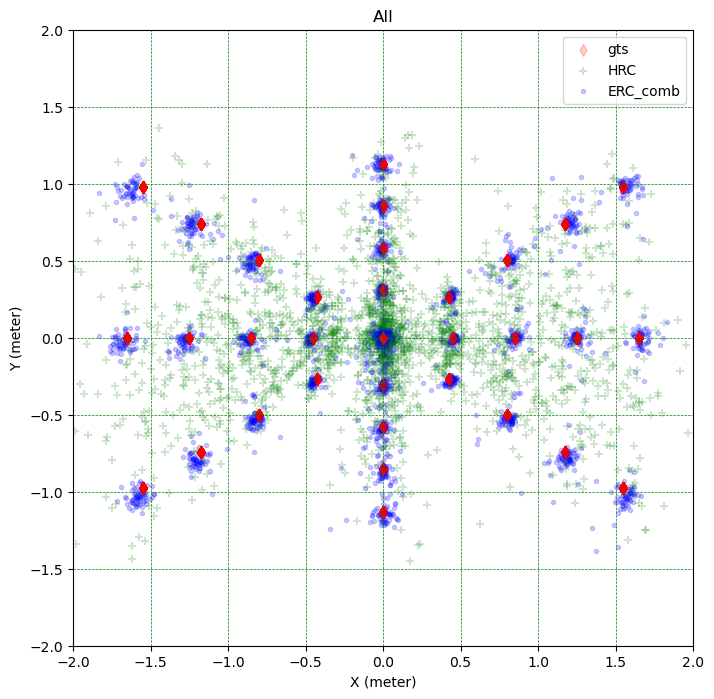

In [3]:
# draw_features_by_file(file_name, save_name, ffile, sfile)
draw_features_by_file(file_name, "testtest", ffile, sfile, PARAMS)